In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score as accuracy
%matplotlib inline

In [ ]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,label=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.label = label
    
    def is_terminal(self):
        return self.label is not None

In [ ]:

class DecisionTree:
    def __init__(self, max_depth=100, min_samples_split=2,scoring='entropy'):
      self.max_depth = max_depth
      self.min_samples_split = min_samples_split
      self.scoring=scoring
      self.root = None
        
    def score(self, y):
      if self.scoring is 'gini':
        return self.gini_index(y)
      if self.scoring is 'entropy':
        return self.entropy(y)
      if self.scoring is 'mer':
        return self.mer(y);

    def is_finished(self, depth):
      if (depth >= self.max_depth or self.n_class_labels == 1 or self.n_samples < self.min_samples_split):
        return True
      return False
    
    def entropy(self, y):
      prob = np.bincount(y) / len(y)
      return -np.sum([p * np.log2(p) for p in prob if p > 0])
      

    def gini_index(self,y):
      prob = np.bincount(y) / len(y)
      return 1-np.sum(prob**2)

    def mer(self,y):
      prob=np.bincount(y) / len(y)
      j=np.argmax(prob)
      
      return 1-prob[j]

    def create_split(self, X, thresh):
      l_idx = np.argwhere(X <= thresh).flatten()
      r_idx = np.argwhere(X > thresh).flatten()
      return l_idx, r_idx
        

    def goodness(self, X, y, thresh):
      parent_loss = self.score(y)
      l_idx, r_idx = self.create_split(X, thresh)
      n, n_left, n_right = len(y), len(l_idx), len(r_idx)

      if n_left == 0 or n_right == 0: 
        return 0
      
      child_loss = (n_left / n) * self.score(y[l_idx]) + (n_right / n) * self.score(y[r_idx])
      return parent_loss - child_loss

    def best_split(self, X, y, features):

      split = {'score': -1, 'feat': None, 'thresh': None}

      for feat in features:
        X_feat = X[:, feat]
        thresholds = np.unique(X_feat)
        for thresh in thresholds:
          score = self.goodness(X_feat, y, thresh)
          if score > split['score']:
            split['score'] = score
            split['feat'] = feat
            split['thresh'] = thresh
      return split['feat'], split['thresh']


    def build_tree(self, X, y, depth=0,forest=0):
      self.n_samples, self.n_features = X.shape
      self.n_class_labels = len(np.unique(y))
      if forest is 1:### for random forest
        self.feats=[]
        for i in range(self.n_features):
          if(np.random.randint(2)):
            self.feats.append(i)
        if(len(self.feats)==0):
          self.feats=range(self.n_features)
      else:
        self.feats=range(self.n_features)
      # stopping criteria
      if self.is_finished(depth):
        most_common_Label = np.argmax(np.bincount(y))
        return Node(label=most_common_Label)  
      #get best split
      best_feat, best_thresh = self.best_split(X, y, self.feats)

      # grow children recursively
      l_idx, r_idx = self.create_split(X[:, best_feat], best_thresh)
      if(len(r_idx) is 0 or len(l_idx) is 0):
        return Node(label=np.argmax(np.bincount(y)))
      else :
        left_child = self.build_tree(X[l_idx, :], y[l_idx], depth + 1)
        right_child = self.build_tree(X[r_idx, :], y[r_idx], depth + 1)
        return Node(best_feat, best_thresh, left_child, right_child)

    def fit(self, X, y,forest=0):
      self.root = self.build_tree(X, y,0,forest)

    def traverse(self, x, node):
      if node.is_terminal():
        return node.label
      if x[node.feature] <= node.threshold:
        return self.traverse(x, node.left)
      return self.traverse(x, node.right)

    def predict(self, X):
      predictions = [self.traverse(x, self.root) for x in X]
      return np.array(predictions)

In [ ]:
class RandomForest:
  def __init__(self, max_depth=100, min_samples_split=2,size=100,scoring='entropy',batch_size=256):
    self.max_depth = max_depth
    self.min_samples_split = min_samples_split
    self.size=size
    self.root = None
    self.scoring=scoring
    self.batch_size=batch_size
  def fit(self, X, y,):
    self.classes=len(np.unique(y))
    self.trees=[]
    for i in range(self.size):
      z=np.random.choice(X.shape[0],int(self.batch_size),replace=True)
      tree=DecisionTree(max_depth=self.max_depth,min_samples_split=self.min_samples_split,scoring=self.scoring)
      tree.fit(X[z,:],y[z],forest=1)
      self.trees.append(tree)
      if i%20 is 0:
        print(i)
  def predict(self,X):
    pred=np.zeros((X.shape[0],self.classes))
    for i in range(self.size):
      y=self.trees[i].predict(X)
      for j in range(len(y)):
        pred[j,y[j]]=pred[j,y[j]]+1
    pred_ = np.argmax(pred,axis=1)
    return pred_
    

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/harjotspahwa/Car-Evaluation/master/car_evaluation.csv',header =None)

In [ ]:
df[0][1]=3
df[0] = df[0].replace(['vhigh','high','med','low'],[3,2,1,0])
df[1] = df[1].replace(['vhigh','high','med','low'],[3,2,1,0])

In [ ]:
df[4]=df[4].replace(['big','med','small'],[2,1,0])
df[5]=df[5].replace(['high','med','low'],[3,2,1])

df[2]=df[2].replace(['5more','2','3','4'],[5,2,3,4])
df[3]=df[3].replace(['more','2','4'],[6,2,4])

In [ ]:
df[6]=df[6].replace(['vgood','good','acc','unacc'],[3,2,1,0])

In [ ]:
df[6]=df[6].replace(['vgood','good','acc','unacc'],[3,2,1,0])

In [ ]:
 X , y = df[[0,1,2,3,4,5]].to_numpy(), df[6].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3,
    )

In [ ]:
tree = DecisionTree(max_depth=10)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9576107899807321


In [ ]:
tree = DecisionTree(max_depth=10,scoring='gini')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9595375722543352


In [ ]:
tree = DecisionTree(max_depth=10,scoring='mer')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.838150289017341


In [ ]:
forest = RandomForest(max_depth=10,size=100,batch_size=512)
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)
acc= accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.9691714836223507


In [ ]:
forest = RandomForest(max_depth=10,size=100,batch_size=512,scoring='gini')
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)
acc= accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.9633911368015414


In [ ]:
forest = RandomForest(max_depth=10,size=100,batch_size=512,scoring='mer')
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)
acc= accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.8285163776493256


In [ ]:
data = sns.load_dataset('iris')

In [ ]:
data['species']=data['species'].replace(['setosa', 'versicolor', 'virginica'],[2,1,0])

In [ ]:
 X = data[['sepal_length','sepal_width','petal_length','petal_width']].to_numpy()
 y= data['species'].to_numpy()

In [ ]:
X_train , X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3
    )

In [ ]:
tree = DecisionTree(max_depth=10)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
acc_t,acc_v = accuracy(y_train,tree.predict(X_train)),accuracy(y_test, y_pred)
print("Accuracy:", acc_t,acc_v)

Accuracy: 1.0 0.9555555555555556


In [ ]:
tree = DecisionTree(max_depth=10,scoring='gini')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
acc_t,acc_v = accuracy(y_train,tree.predict(X_train)),accuracy(y_test, y_pred)
print("Accuracy:", acc_t,acc_v)

Accuracy: 1.0 0.9555555555555556


In [ ]:
tree = DecisionTree(max_depth=10,scoring='mer')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
acc_t,acc_v = accuracy(y_train,tree.predict(X_train)),accuracy(y_test, y_pred)
print("Accuracy:", acc_t,acc_v)

Accuracy: 0.9904761904761905 0.9555555555555556


In [ ]:
forest = RandomForest(max_depth=10,size=100,batch_size=500,scoring='entropy')
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)
acc= accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.9555555555555556


In [ ]:
forest = RandomForest(max_depth=10,size=100,batch_size=500,scoring='gini')
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)
acc= accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.9555555555555556


In [ ]:
forest = RandomForest(max_depth=10,size=100,batch_size=500,scoring='mer')
forest.fit(X_train,y_train)
y_pred=forest.predict(X_test)
acc= accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.9555555555555556


In [ ]:
bc=pd.read_csv('/content/data.csv')

In [ ]:
bc['diagnosis'].unique()

array(['M', 'B'], dtype=object)

In [ ]:
bc['diagnosis']=bc['diagnosis'].replace(['M','B'],[1,0])

In [ ]:
bc=bc.drop(columns='Unnamed: 32')

In [ ]:
X=bc[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].to_numpy()

y=bc['diagnosis'].to_numpy()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=2
    )
len(X_test)
len(y_test)

228

In [ ]:
tree = DecisionTree(max_depth=10,scoring='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9166666666666666


In [ ]:
tree = DecisionTree(max_depth=10,scoring='gini')
tree.fit(X_train, y_train)
y_pred= tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.9078947368421053


In [ ]:
tree = DecisionTree(max_depth=10,scoring='mer')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.9122807017543859


In [ ]:
forest = RandomForest(max_depth=10,size=100)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.9429824561403509


In [ ]:
forest = RandomForest(max_depth=10,size=100,scoring='gini')
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.9298245614035088


In [ ]:
forest = RandomForest(max_depth=10,size=100,scoring='mer')
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:",acc)

0
20
40
60
80
Accuracy: 0.9342105263157895


In [ ]:
ecoli=pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/ecoli.csv',header=None)

In [ ]:
ecoli.columns

Int64Index([0, 1, 2, 3, 4, 5, 6, 7], dtype='int64')

In [ ]:
ecoli[7]=ecoli[7].replace(['cp', 'im', 'imS', 'imL', 'imU', 'om', 'omL', 'pp'],range(8))

In [ ]:
X=ecoli[range(7)].to_numpy()
y=ecoli[7].to_numpy()
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3,
    )
len(X_test)
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
tree = DecisionTree(max_depth=10)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8316831683168316


In [ ]:
tree = DecisionTree(max_depth=10,scoring='gini')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8316831683168316


In [ ]:
tree = DecisionTree(max_depth=10,scoring='mer')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8217821782178217


In [ ]:
forest = RandomForest(max_depth=10,size=100,scoring='entropy')
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

0
20
40
60
80
Accuracy: 0.8514851485148515


In [ ]:
forest = RandomForest(max_depth=10,size=100,scoring='gini')
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

0
20
40
60
80
Accuracy: 0.8415841584158416


In [ ]:
forest = RandomForest(max_depth=10,size=100,scoring='mer')
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

0
20
40
60
80
Accuracy: 0.8415841584158416


In [ ]:
letter=pd.read_csv('https://datahub.io/machine-learning/letter/r/letter.csv')

In [ ]:
letter

,x-box,y-box,width,high,onpix,x-bar,y-bar,x2bar,y2bar,xybar,x2ybr,xy2br,x-ege,xegvy,y-ege,yegvx,class
0,2,4,4,3,2,7,8,2,9,11,7,7,1,8,5,6,Z
1,4,7,5,5,5,5,9,6,4,8,7,9,2,9,7,10,P
2,7,10,8,7,4,8,8,5,10,11,2,8,2,5,5,10,S
3,4,9,5,7,4,7,7,13,1,7,6,8,3,8,0,8,H
4,6,7,8,5,4,7,6,3,7,10,7,9,3,8,3,7,H
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,5,10,5,8,3,4,10,7,8,12,10,9,2,9,2,6,C
19996,4,7,6,5,3,7,8,2,10,12,6,8,1,9,6,8,Z
19997,4,8,4,6,4,7,8,7,4,10,7,6,3,9,3,7,O
19998,4,11,4,8,3,0,2,4,6,1,0,7,0,8,0,8,L


In [ ]:
letter['class'].unique()


array(['Z', 'P', 'S', 'H', 'F', 'N', 'R', 'M', 'D', 'V', 'A', 'K', 'E',
       'O', 'Q', 'L', 'X', 'Y', 'I', 'W', 'U', 'T', 'C', 'G', 'B', 'J'],
      dtype=object)

In [ ]:
letter['class']=letter['class'].replace(['Z', 'P', 'S', 'H', 'F', 'N', 'R', 'M', 'D', 'V', 'A', 'K', 'E',
       'O', 'Q', 'L', 'X', 'Y', 'I', 'W', 'U', 'T', 'C', 'G', 'B', 'J'],range(26))

In [ ]:
X=letter[[ 	'x-box', 	'y-box', 	'width', 	'high' ,	'onpix' ,	'x-bar', 	'y-bar' ,	'x2bar' ,	'y2bar' 	,'xybar', 	'x2ybr' 	,'xy2br' , 	'x-ege' , 	'xegvy' , 	'y-ege' ,	'yegvx']].to_numpy()
len(X)

20000

In [ ]:
y=letter['class'].to_numpy()
len(y)

20000

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3,
    )
len(X_test)
len(np.unique(y_train))

26

In [ ]:
tree = DecisionTree(max_depth=15,scoring='entropy')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8688333333333333


In [ ]:
tree = DecisionTree(max_depth=15,scoring='gini')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)


Accuracy: 0.8151666666666667


In [ ]:
tree = DecisionTree(max_depth=15,scoring='mer')
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.8191666666666667


In [ ]:
forest = RandomForest(max_depth=15,size=100,scoring='entropy',batch_size=2048)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

0
20
40
60
80
Accuracy: 0.9101666666666667


In [ ]:
forest = RandomForest(max_depth=10,size=100,scoring='gini',batch_size=2048)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

0
20
40
60
80
Accuracy: 0.8875


In [ ]:
forest = RandomForest(max_depth=10,size=100,scoring='mer',batch_size=2048)
forest.fit(X_train, y_train)
y_pred = forest.predict(X_test)
acc = accuracy(y_test, y_pred)
print("Accuracy:", acc)

0
20
40
60
80
Accuracy: 0.8638333333333333


In [ ]:
labels = ['vgood','good','acc','unacc']

x0=len(df[df['hours']==0])
x1=len(df[df['hours']==1])
x2=len(df[df['hours']==2])
x3=len(df[df['hours']==3])
x4=len(df[df['hours']==4])
data=[x0,x1,x2,x3,x4]
#define Seaborn color palette to use
#create pie chart
colors = sns.color_palette('pastel')[0:5]
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.title("Gaming Time")
plt.savefig('hour.png', bbox_inches='tight')
plt.show()
np.mean(df_m['well'])

In [ ]:
tips = sns.load_dataset("tips")

In [ ]:
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


In [ ]:
data = {'Accuracy': accuracy, 'Metric':metric,'Data Set':Dataset}

In [ ]:
df = pd.DataFrame(data)  

In [ ]:
accuracy=[98.07,98.84,81.69, 97.49,97.68,87.09,95.55,95.55,95.55,95.55,95.55,95.55,83.16,83.16,82.17,85.14,84.15,84.15, 91.66,90.78,91.22,94.29,92.98,93.42,86.88,81.51,81.91,91.01,88.75,86.38]
metric=['Decision tree-Entropy','Decision tree-Gini Index','Decision tree-MER','Random forest-Entropy','Random forest-Gini Index','Random forest-MER','Decision tree-Entropy','Decision tree-Gini Index','Decision tree-MER','Random forest-Entropy','Random forest-Gini Index','Random forest-MER','Decision tree-Entropy','Decision tree-Gini Index','Decision tree-MER','Random forest-Entropy','Random forest-Gini Index','Random forest-MER','Decision tree-Entropy','Decision tree-Gini Index','Decision tree-MER','Random forest-Entropy','Random forest-Gini Index','Random forest-MER','Decision tree-Entropy','Decision tree-Gini Index','Decision tree-MER','Random forest-Entropy','Random forest-Gini Index','Random forest-MER']

In [ ]:
len(accuracy)
len(metric)

30

In [ ]:
Dataset=['Car Evaluation','Car Evaluation','Car Evaluation','Car Evaluation','Car Evaluation','Car Evaluation','Iris','Iris','Iris','Iris','Iris','Iris','Ecoli','Ecoli','Ecoli','Ecoli','Ecoli','Ecoli','Breast Cancer','Breast Cancer','Breast Cancer','Breast Cancer','Breast Cancer','Breast Cancer','Letter Recognition','Letter Recognition','Letter Recognition','Letter Recognition','Letter Recognition','Letter Recognition']
len(Dataset)

30

In [ ]:
df['Metrix'].unique()

KeyError: ignored

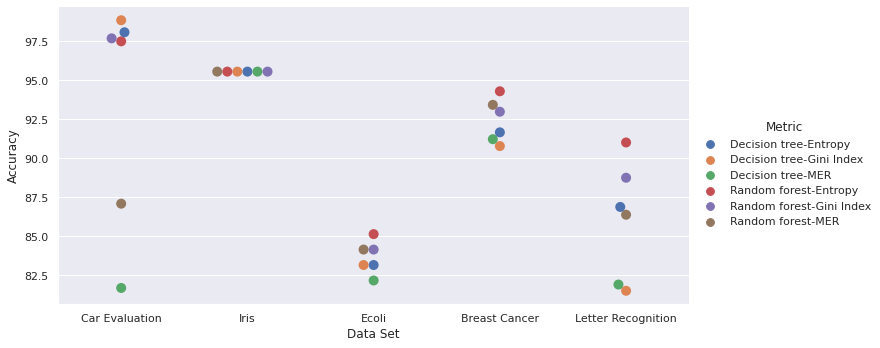

In [ ]:

sns.catplot(x="Data Set", y="Accuracy", hue="Metric", kind="swarm", data=df,height=5,aspect=2,s=10)
plt.savefig('data.png')
plt.show()